In [81]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [2]:
response=llm.invoke("hi my self sunny")

In [3]:
response.content

"Hello Sunny! It's nice to meet you. 😊 \n\nWhat can I do for you today?\n"

In [4]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [5]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [6]:
multiply({"first_number":24,"second_number":364})

C:\Users\sunny\AppData\Local\Temp\ipykernel_72156\2089873997.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"first_number":24,"second_number":364})


8736

In [7]:
@tool
def search(query: str):
    """perform web search on the user query"""
    tavily = TavilySearchResults(max_results=1)
    result = tavily.invoke(query)
    return result

In [8]:
search("who is current indian prime minister?")

[{'url': 'https://en.wikipedia.org/wiki/Narendra_Modi',
  'content': 'In the campaign, the opposition targeted Modi on allegations of corruption over the Rafale deal with the Government of France, highlighting the controversy surrounding the deal.[227] Modi\'s campaign focused on defence and national security, especially after the Pulwama attack and the retaliatory Balakot airstrike, which was counted as an achievement of his administration.[17][228] Other topics in the campaign were development and good foreign relations in the first premiership.[229]\nModi contested the Lok Sabha election as a candidate for Varanasi; he won the seat by a margin of 479,505 votes, defeating Shalini Yadav of the Samajwadi Party (SP), who stood as a candidate for the SP-BSP alliance.[230][231] Modi was unanimously appointed prime minister for a second time by the National Democratic Alliance[232] after the alliance won the election for the second time with 353 seats in the Lok Sabha; the BJP alone won 30

In [9]:
tools = [search,multiply]

In [10]:
for tool in tools:
    print({tool.name: tool})

{'search': StructuredTool(name='search', description='perform web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002009B955480>)}
{'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002009DFB0160>)}


In [11]:
tool_map = {tool.name: tool for tool in tools}

In [12]:
tool_map

{'search': StructuredTool(name='search', description='perform web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002009B955480>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002009DFB0160>)}

In [13]:
model_with_tools = llm.bind_tools(tools)

In [14]:
res = model_with_tools.invoke('Search from internet and tell me who won the T20 Cricket world cup in 2024?')

In [15]:
res

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_h0b4', 'function': {'arguments': '{"query":"Who won the T20 Cricket world cup in 2024?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1089, 'total_tokens': 1181, 'completion_time': 0.167272727, 'prompt_time': 0.034844753, 'queue_time': 0.002959996999999999, 'total_time': 0.20211748}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f165c568-e00e-459a-97dc-5b6f6c7ffdc6-0', tool_calls=[{'name': 'search', 'args': {'query': 'Who won the T20 Cricket world cup in 2024?'}, 'id': 'call_h0b4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1089, 'output_tokens': 92, 'total_tokens': 1181})

In [16]:
for name in ["savita"]:
    print(name)

savita


In [17]:
name

'savita'

In [35]:
tool_details=res.additional_kwargs.get("tool_calls", [])[0]

In [36]:
tool_details

{'id': 'call_h0b4',
 'function': {'arguments': '{"query":"Who won the T20 Cricket world cup in 2024?"}',
  'name': 'search'},
 'type': 'function'}

In [37]:
tool_map[tool_details['function']['name']]

StructuredTool(name='search', description='perform web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002009B955480>)

In [38]:
tool_details['function']['arguments']

'{"query":"Who won the T20 Cricket world cup in 2024?"}'

In [39]:
tool_map[tool_details['function']['name']].invoke(tool_details['function']['arguments'])

[{'url': 'https://github.com/aritrasen87/LLM_RAG_Model_Deployment/blob/main/LangGraph_05_Bring_Human_In_the_loop_Agents.ipynb',
  'content': "... query', args_schema=<class 'pydantic.v1.main ... who won the T20 Cricket world cup in 2024?') for ... Who won the T20 Cricket world cup in 2024?"}]

In [44]:
from typing import TypedDict, Annotated, Sequence
import operator,json
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [45]:
def invoke_model(state):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [46]:
def invoke_tool(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    tool_details = None

    for tool_call in tool_calls:
        tool_details = tool_call

    if tool_details is None:
        raise Exception("No adder input found.")

    print(f'Selected tool: {tool_details.get("function").get("name")}')

    if tool_details.get("function").get("name") == "search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise ValueError

    response = tool_map[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [47]:

from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("agent", invoke_model)

graph.add_node("tool", invoke_tool)

def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

graph.add_conditional_edges("agent", router, {
    "tool": "tool",
    "end": END,
})

graph.add_edge("tool", END)

graph.set_entry_point("agent")

In [48]:
app = graph.compile()

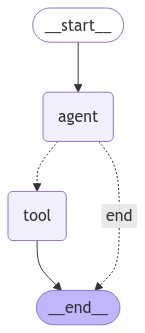

In [49]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [50]:

for s in app.stream({"messages": ["What is 24 * 365?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gf96', 'function': {'arguments': '{"first_number":24,"second_number":3365}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1078, 'total_tokens': 1171, 'completion_time': 0.169090909, 'prompt_time': 0.035238778, 'queue_time': 0.003483271000000003, 'total_time': 0.204329687}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-aad51563-6d77-4f86-bfdb-d547e1f566ba-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 24, 'second_number': 3365}, 'id': 'call_gf96', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1078, 'output_tokens': 93, 'total_tokens': 1171})]}
----
Selected tool: multiply
{'messages': [80760]}
----


In [51]:
for s in app.stream({"messages": ["Who won the T20 Cricket world cup in 2024?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w542', 'function': {'arguments': '{"query":"who won the T20 Cricket world cup in 2024"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 1083, 'total_tokens': 1177, 'completion_time': 0.170909091, 'prompt_time': 0.035069939, 'queue_time': 0.0030248579999999983, 'total_time': 0.20597903}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6bb884aa-f080-42f3-9e17-790bcc3f0cbe-0', tool_calls=[{'name': 'search', 'args': {'query': 'who won the T20 Cricket world cup in 2024'}, 'id': 'call_w542', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1083, 'output_tokens': 94, 'total_tokens': 1177})]}
----
Selected tool: search
{'messages': [[{'url': "https://en.wikipedia.org/wiki/2024_ICC_Men's_T20_World_Cup_final", 'content': "The 2024 ICC Men's T20 World Cup fina

In [52]:
for s in app.stream({"messages": ["Who won the T20 Cricket world cup in 2024?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q7s2', 'function': {'arguments': '{"query":"who won the T20 Cricket world cup in 2024"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1083, 'total_tokens': 1175, 'completion_time': 0.167272727, 'prompt_time': 0.036009145, 'queue_time': 0.0033453550000000012, 'total_time': 0.203281872}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b5199888-293b-408e-b1e1-237389edb9c5-0', tool_calls=[{'name': 'search', 'args': {'query': 'who won the T20 Cricket world cup in 2024'}, 'id': 'call_q7s2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1083, 'output_tokens': 92, 'total_tokens': 1175})]}
----
Selected tool: search


ValueError: 

**Breakpoints** are a common HIL interaction pattern, allowing the graph to stop at specific steps and seek human approval before proceeding.

**Breakpoints** are built on top of LangGraph checkpoints, which save the graph's state after each node execution.

**Checkpoints** are saved in threads that preserve graph state and can be accessed after a graph has finished execution.

## **Benefits:**

- Graph execution to pause at specific points
- Await human approval
- Resume execution from the last checkpoint.

In [3]:
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.graph.message import add_messages
import operator

In [4]:
class State(TypedDict):
    messages: Annotated[list, operator.add]

In [41]:
def function_1(state):
    return {"messages" : ["First Function "]}

def function_2(state):
    return {"messages" : ["Second Function "]}

def function_3(state):
    return {"messages" : ["Third Function "]}

In [42]:
graph=StateGraph(State)

In [43]:
graph.add_node("step_1", function_1)
graph.add_node("step_2", function_2)
graph.add_node("step_3", function_3)

In [44]:
graph.add_edge(START, "step_1")
graph.add_edge("step_1", "step_2")
graph.add_edge("step_2", "step_3")
graph.add_edge("step_3", END)



In [45]:
memory = MemorySaver()

In [46]:
application = graph.compile(checkpointer=memory, interrupt_before=["step_3"])

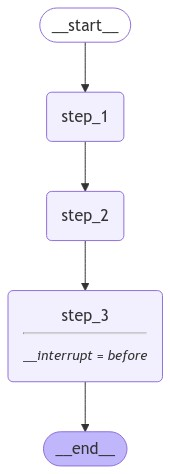

In [47]:
display(Image(application.get_graph().draw_mermaid_png()))

In [48]:
initial_input={"messages":["hello lang graph"]}

In [49]:
thread = {"configurable": {"thread_id":"1"}}

In [50]:
response=application.stream(initial_input,thread)

In [51]:
for event in response:
    print(event)

{'step_1': {'messages': ['First Function ']}}
{'step_2': {'messages': ['Second Function ']}}


In [52]:
response=application.stream(initial_input,thread,stream_mode="values")

In [53]:
for event in response:
    print(event)

{'messages': ['hello lang graph', 'First Function ', 'Second Function ', 'hello lang graph']}
{'messages': ['hello lang graph', 'First Function ', 'Second Function ', 'hello lang graph', 'First Function ']}
{'messages': ['hello lang graph', 'First Function ', 'Second Function ', 'hello lang graph', 'First Function ', 'Second Function ']}


In [54]:
application.get_state(thread)

StateSnapshot(values={'messages': ['hello lang graph', 'First Function ', 'Second Function ', 'hello lang graph', 'First Function ', 'Second Function ']}, next=('step_3',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef99ca9-5228-6ee4-8006-54b7fb1140a7'}}, metadata={'source': 'loop', 'writes': {'step_2': {'messages': ['Second Function ']}}, 'step': 6, 'parents': {}}, created_at='2024-11-03T10:01:23.628822+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef99ca9-5228-6ee3-8005-86ef43db9403'}}, tasks=(PregelTask(id='b79e6d5a-8c71-afb8-b0a0-fa88a0523755', name='step_3', path=('__pregel_pull', 'step_3'), error=None, interrupts=(), state=None),))

In [55]:
snapshot=application.get_state(thread)

In [56]:
snapshot.next

('step_3',)

In [28]:
thread={"configurable":{"thread_id":"2"}}

In [30]:
event=application.stream(None, thread, stream_mode="values")

In [31]:
for response in event:
    print(response)

EmptyInputError: Received no input for __start__

In [57]:
thread={"configurable":{"thread_id":"1"}}

In [65]:
event=application.stream(None, thread, stream_mode="values")

In [66]:
for response in event:
    print(response)

{'messages': ['hello lang graph', 'First Function ', 'Second Function ', 'hello lang graph', 'First Function ', 'Second Function ', 'Third Function ']}


In [64]:
event=application.stream(None, thread)

In [61]:
for response in event:
    print(response)

In [69]:
snapshot=application.get_state(thread)

In [70]:
snapshot.next

()

#### Checkpointing plus Breakpointing with ToolCalling

In [71]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [72]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [73]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [74]:
memory=MemorySaver()

In [76]:
StateGraph(State)

In [78]:
tool=TavilySearchResults(max_results=2)

In [79]:
tools=[tool]

In [82]:
llm_with_tools=llm.bind_tools(tools)

In [88]:
llm_with_tools.invoke(["hi"])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dsb6', 'function': {'arguments': '{"query":"hi"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 982, 'total_tokens': 1069, 'completion_time': 0.158181818, 'prompt_time': 0.032244809, 'queue_time': 0.003470418000000003, 'total_time': 0.190426627}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11984ce4-0170-4226-b7fd-c1bba9c56039-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'hi'}, 'id': 'call_dsb6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 982, 'output_tokens': 87, 'total_tokens': 1069})

In [87]:
llm_with_tools.invoke(["hi"]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'hi'},
  'id': 'call_0ym3',
  'type': 'tool_call'}]

In [89]:
def Agent(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [90]:
tool_node=ToolNode(tools=[tool])

In [91]:
app2=StateGraph(State)

In [92]:
app2.add_node("Agent",Agent)
app2.add_node("tools",tool_node)

In [93]:
app2.add_conditional_edges(
    "Agent",
    tools_condition,
)

In [94]:
app2.add_edge("tools","Agent")

In [95]:
app2.set_entry_point("Agent")

In [98]:
graph=app2.compile(checkpointer=memory, interrupt_before=["tools"])

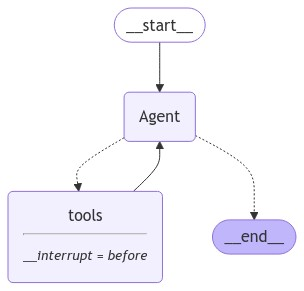

In [99]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [100]:
from langchain_core.messages import HumanMessage

In [101]:
{"messages":HumanMessage(content="hello i am sunny belong to bangalore")}

{'messages': HumanMessage(content='hello i am sunny belong to bangalore', additional_kwargs={}, response_metadata={})}

In [102]:
input_message={"messages":HumanMessage(content="hello i am sunny belong to bangalore")}

In [103]:
thread={"configurable":{"thread_id":"1"}}

In [105]:
for event in graph.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

hello i am sunny belong to bangalore
None
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bm9s)
 Call ID: call_bm9s
  Args:
    query: Sunny from Bangalore
None


In [106]:

# Input
input_message = {'messages':HumanMessage(content="Sorry where I am from?")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())
     

================================ Human Message =================================

Sorry where I am from?
None
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bpsv)
 Call ID: call_bpsv
  Args:
    query: Sunny from Bangalore
None


In [107]:

# Input
input_message = {'messages':HumanMessage(content="What is there weather there?")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

What is there weather there?
None
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_gft5)
 Call ID: call_gft5
  Args:
    query: Weather in Bangalore
None


In [109]:
# Run the graph until the first interruption
for event in graph.stream(None, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_gft5)
 Call ID: call_gft5
  Args:
    query: Weather in Bangalore
None
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Bangalore', 'region': 'Karnataka', 'country': 'India', 'lat': 12.9833, 'lon': 77.5833, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1730631852, 'localtime': '2024-11-03 16:34'}, 'current': {'last_updated_epoch': 1730631600, 'last_updated': '2024-11-03 16:30', 'temp_c': 27.0, 'temp_f': 80.6, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 7.6, 'wind_kph': 12.2, 'wind_degree': 85, 'wind_dir': 'E', 'pressure_mb': 1014.0, 'pressure_in': 29.94, 'precip_mm': 0.03, 'precip_in': 0.0, 'humidity': 58, 'cloud': 50, 'feelslike_c'

In [112]:

# Input
input_message = {'messages':HumanMessage(content="What are the best foods to explore there?")}

# Run the graph until the first interruption
for event in graph.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

What are the best foods to explore there?
None
================================== Ai Message ==================================

Bangalore is known for its diverse culinary scene!  You should definitely try some of these local favorites:

* **Dosa:** A thin, crispy crepe made from fermented rice and lentil batter, served with various fillings and chutneys.
* **Idli:** Steamed rice cakes, soft and fluffy, often served with sambar and chutney.
* **Vada:** Savory lentil fritters, crispy on the outside and soft on the inside.
* **Bisi Bele Bath:** A hearty one-pot rice dish with lentils, vegetables, and a spicy gravy.
* **Mysore Masala Dosa:** A dosa stuffed with spiced potatoes and served with a flavorful chutney.
* **Biryani:** Aromatic rice dish cooked with meat, vegetables, and spices.
* **Chicken 65:** Deep-fried chicken marinated in a spicy blend of ginger, garlic, and chili powder.



Enjoy your culina

In [115]:

# Input
input_message = {'messages':HumanMessage(content="Tell me about the recent incident happening there?")}

# Run the graph until the first interruption
for event in graph.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())
     

================================ Human Message =================================

Tell me about the recent incident happening there?
None
================================== Ai Message ==================================

I need more information to understand which incident you're referring to. 

Bangalore, like any large city, experiences various events daily.  

To help me find the specific incident you're interested in, could you please provide some more details? For example:

* **What type of incident are you asking about?** (e.g., a crime, a natural disaster, a protest)
* **When did this incident occur?** (e.g., today, yesterday, last week)
* **Do you have any other keywords related to the incident?** 



With more context, I can try to find relevant information for you.
None


In [116]:
snapshot = graph.get_state(thread)

In [117]:
current_message = snapshot.values["messages"][-1]

In [118]:
current_message

AIMessage(content="I need more information to understand which incident you're referring to. \n\nBangalore, like any large city, experiences various events daily.  \n\nTo help me find the specific incident you're interested in, could you please provide some more details? For example:\n\n* **What type of incident are you asking about?** (e.g., a crime, a natural disaster, a protest)\n* **When did this incident occur?** (e.g., today, yesterday, last week)\n* **Do you have any other keywords related to the incident?** \n\n\n\nWith more context, I can try to find relevant information for you. \n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 139, 'prompt_tokens': 2198, 'total_tokens': 2337, 'completion_time': 0.252727273, 'prompt_time': 0.071492829, 'queue_time': 0.0038338800000000117, 'total_time': 0.324220102}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-2ce28347-a08a-42d4-a8d6-1

In [119]:
current_message.pretty_print()

================================== Ai Message ==================================

I need more information to understand which incident you're referring to. 

Bangalore, like any large city, experiences various events daily.  

To help me find the specific incident you're interested in, could you please provide some more details? For example:

* **What type of incident are you asking about?** (e.g., a crime, a natural disaster, a protest)
* **When did this incident occur?** (e.g., today, yesterday, last week)
* **Do you have any other keywords related to the incident?** 



With more context, I can try to find relevant information for you.


In [120]:
tool_call_id = current_message.tool_calls[0]["id"] 

IndexError: list index out of range

In [121]:
tool_call_id

NameError: name 'tool_call_id' is not defined

In [122]:
from langchain_core.messages import AIMessage, ToolMessage

answer = """The protest is about an unfortune incident with a lady Doctor in R.G.Kar hospital in Kolkata, as a protest against the adiministration.
People are using a slogan - "#WeWantJustice"! """
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

NameError: name 'tool_call_id' is not defined

In [125]:
graph.update_state(
    thread,
    {"messages": new_messages},
)

NameError: name 'new_messages' is not defined

In [127]:

print(graph.get_state(thread).values["messages"][-1:])

[AIMessage(content="I need more information to understand which incident you're referring to. \n\nBangalore, like any large city, experiences various events daily.  \n\nTo help me find the specific incident you're interested in, could you please provide some more details? For example:\n\n* **What type of incident are you asking about?** (e.g., a crime, a natural disaster, a protest)\n* **When did this incident occur?** (e.g., today, yesterday, last week)\n* **Do you have any other keywords related to the incident?** \n\n\n\nWith more context, I can try to find relevant information for you. \n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 139, 'prompt_tokens': 2198, 'total_tokens': 2337, 'completion_time': 0.252727273, 'prompt_time': 0.071492829, 'queue_time': 0.0038338800000000117, 'total_time': 0.324220102}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-2ce28347-a08a-42d4-a8d6-